In [1]:
import os, sys
import datetime
from datetime import datetime, date, timedelta
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.plotting import scatter_matrix
from pandas_profiling import ProfileReport
import mglearn
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format = 'svg'
from mpl_toolkits.mplot3d import Axes3D, axes3d
from scipy import sparse
import scipy.stats as ss
import scipy.cluster.hierarchy as sch
import pingouin as pg
import spacy, nltk
from konlpy.tag import Okt

c:\Users\admin\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [33]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

In [3]:
data_df = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, 'adult.data'), header=None, index_col=False, 
names = ['age', 'workclass', 'fnlwgt', 'education',  'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'gender',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
           'income'])
data = data_df.loc[:, ['age', 'workclass', 'education', 'gender', 'hours-per-week', 'occupation', 'income']]
data.head()

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K


In [4]:
pd.concat([data.dtypes, data.nunique()], axis=1)

,0,1
age,int64,73
workclass,object,9
education,object,16
gender,object,2
hours-per-week,int64,94
occupation,object,15
income,object,2


In [5]:
# dtypes에서 확인할 때 object일 경우에는 자동으로 변환
# columns 파라미터 추가로 변환하고 싶은 열 설정 가능
data_dummies = pd.get_dummies(data)
list(data.columns), list(data_dummies.columns)

(['age',
  'workclass',
  'education',
  'gender',
  'hours-per-week',
  'occupation',
  'income'],
 ['age',
  'hours-per-week',
  'workclass_ ?',
  'workclass_ Federal-gov',
  'workclass_ Local-gov',
  'workclass_ Never-worked',
  'workclass_ Private',
  'workclass_ Self-emp-inc',
  'workclass_ Self-emp-not-inc',
  'workclass_ State-gov',
  'workclass_ Without-pay',
  'education_ 10th',
  'education_ 11th',
  'education_ 12th',
  'education_ 1st-4th',
  'education_ 5th-6th',
  'education_ 7th-8th',
  'education_ 9th',
  'education_ Assoc-acdm',
  'education_ Assoc-voc',
  'education_ Bachelors',
  'education_ Doctorate',
  'education_ HS-grad',
  'education_ Masters',
  'education_ Preschool',
  'education_ Prof-school',
  'education_ Some-college',
  'gender_ Female',
  'gender_ Male',
  'occupation_ ?',
  'occupation_ Adm-clerical',
  'occupation_ Armed-Forces',
  'occupation_ Craft-repair',
  'occupation_ Exec-managerial',
  'occupation_ Farming-fishing',
  'occupation_ Handlers-cl

In [6]:
X = data_dummies.iloc[:, :-2]
y = data.iloc[:, -1].replace({' <=50K':0, ' >50K':1})
X.shape, y.shape

((32561, 44), (32561,))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [8]:
logreg = LogisticRegression(C=100, max_iter=3000).fit(X_train, y_train)
logreg.score(X_train, y_train), logreg.score(X_test, y_test)

(0.8138001638001638, 0.8086230192851002)

In [9]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=0, n_jobs=-1).fit(X_train, y_train)
rf_clf.score(X_train, y_train), rf_clf.score(X_test, y_test)

(0.8620393120393121, 0.8141505957499079)

In [11]:
ct = ColumnTransformer(
    [('scaling', StandardScaler(), ['age', 'hours-per-week']),
    ('onehot', OneHotEncoder(sparse=False), ['workclass', 'education', 'gender', 'occupation'])]
)

In [15]:
data_features = data.drop('income', axis=1)
X_train, X_test, y_train, y_test = train_test_split(data_features, np.where(data['income'] == ' >50K', 1, 0), random_state=0)

In [17]:
ct.fit(X_train)
X_train_trans = ct.transform(X_train)
X_test_trans = ct.transform(X_test)
X_train_trans.shape

(24420, 44)

In [19]:
logreg = LogisticRegression(C=10, max_iter=1000).fit(X_train_trans, y_train)
logreg.score(X_train_trans, y_train), logreg.score(X_test_trans, y_test)

(0.8136773136773137, 0.808991524382754)

In [20]:
ct.named_transformers_

{'scaling': StandardScaler(), 'onehot': OneHotEncoder(sparse=False)}

In [21]:
ct = make_column_transformer(
    (StandardScaler(), ['age', 'hours-per-week']),
    (OneHotEncoder(sparse=False), ['workclass', 'education', 'gender', 'occupation'])
)

In [22]:
ct.fit(X_train)
X_train_trans = ct.transform(X_train)
X_test_trans = ct.transform(X_test)
X_train_trans.shape

(24420, 44)

In [23]:
logreg = LogisticRegression(C=10, max_iter=1000).fit(X_train_trans, y_train)
logreg.score(X_train_trans, y_train), logreg.score(X_test_trans, y_test)

(0.8136773136773137, 0.808991524382754)

In [28]:
X, y = mglearn.datasets.make_wave(n_samples=120)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

In [29]:
dt_reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X, y)
lr_reg = LinearRegression().fit(X, y)

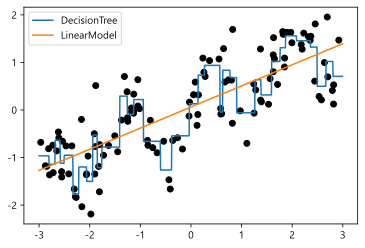

In [32]:
plt.plot(line, dt_reg.predict(line), label='DecisionTree')
plt.plot(line, lr_reg.predict(line), label='LinearModel')
plt.scatter(X[:, 0], y, c='black')
plt.legend()
plt.show()

In [34]:
# strategy는 'uniform'(pd.cut), 'quantile'(pd.qcut), 'kmeans' 존재 → default='quantile'
kb = KBinsDiscretizer(n_bins=10, strategy='uniform').fit(X)
kb.bin_edges_

array([array([-2.9668673 , -2.37804841, -1.78922951, -1.20041062, -0.61159173,
              -0.02277284,  0.56604605,  1.15486494,  1.74368384,  2.33250273,
               2.92132162])                                                   ],
      dtype=object)

In [40]:
X_binned = kb.transform(X)
X[:10], X_binned.toarray()[:10]

(array([[-0.75275929],
        [ 2.70428584],
        [ 1.39196365],
        [ 0.59195091],
        [-2.06388816],
        [-2.06403288],
        [-2.65149833],
        [ 2.19705687],
        [ 0.60669007],
        [ 1.24843547]]),
 array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]))

In [41]:
kb = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='onehot-dense').fit(X)
X_binned = kb.transform(X)
X_binned[:5]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [42]:
line_binned = kb.transform(line)
dt_reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X_binned, y)
lr_reg = LinearRegression().fit(X_binned, y)

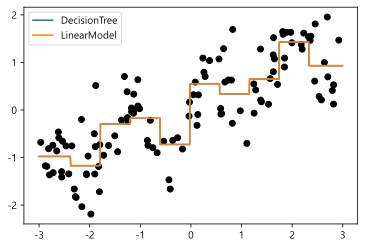

In [44]:
# 선형모델은 유연해졌지만 결정트리는 덜 유연 → 트리모델은 구간화가 득이 되지 않음
plt.plot(line, dt_reg.predict(line_binned), label='DecisionTree')
plt.plot(line, lr_reg.predict(line_binned), label='LinearModel')
plt.scatter(X[:, 0], y, c='black')
plt.legend()
plt.show()

In [48]:
X_combined = np.hstack([X, X_binned])
line_combined = np.hstack([line, line_binned])
dt_reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X_combined, y)
lr_reg = LinearRegression().fit(X_combined, y)

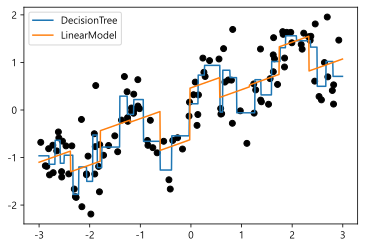

In [47]:
# 선형모델은 유연해졌지만 결정트리는 덜 유연 → 트리모델은 구간화가 득이 되지 않음
plt.plot(line, dt_reg.predict(line_combined), label='DecisionTree')
plt.plot(line, lr_reg.predict(line_combined), label='LinearModel')
plt.scatter(X[:, 0], y, c='black')
plt.legend()
plt.show()

In [53]:
X_product = np.hstack([X * X_binned, X_binned])
line_product = np.hstack([line * line_binned, line_binned])
dt_reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X_product, y)
lr_reg = LinearRegression().fit(X_product, y)

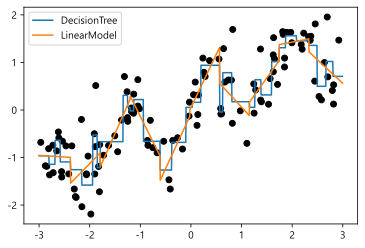

In [54]:
# 선형모델은 유연해졌지만 결정트리는 덜 유연 → 트리모델은 구간화가 득이 되지 않음
plt.plot(line, dt_reg.predict(line_product), label='DecisionTree')
plt.plot(line, lr_reg.predict(line_product), label='LinearModel')
plt.scatter(X[:, 0], y, c='black')
plt.legend()
plt.show()